## 卷积神经网络(Convolutional Neural Networks)
卷积操作、池化操作
深度可分离卷积
数据增强
迁移学习

### 大致结构：
- 卷积神经网络
    - (convolution+subsampling)*n + fully connected layers,FC*m
    - classification
- 全卷积神经网络
    - (convolution+subsampling)*n + pixelwise classification*K
    - Object segment



卷积操作：
解决神经网络参数过多的问题，比如：图片大小为1000*1000， 下一层神经元为10^6，全链接参数为(10^3*10^3)*10^6=10^12，参数过多比较容易过拟合，需要更多训练数据

卷积的特点：
- 局部连接
比如图片大小为1000*1000，下一层神经元为10^6，局部连接范围为10*10，全连接参数为(10*10)*10^6=10^8
- 参数共享
比如图片大小为1000*1000，下一层神经元为10^6，局部连接范围为10*10，全连接参数为10*10=100，ps这里运用了参数共享是指在局部内的像素数据分布相同，在图像中，其实很多局部的图像都是一样的，所以进行参数共享可以有效的优化数据，可能没有上面个提到的优化成100这么恐怖



### 卷积--每个位置进行计算
输入的图像：
```
[
    [1,2,3,4,5],
    [6,7,8,9,10],
    [11,12,13,14,15],
    [16,17,18,19,20],
    [21,22,23,24,25],
]
```
卷积核：
```
[
    [1,0,1],
    [0,1,0],
    [1,0,1],
]
```
输出size=输入size-卷积核size+1
输出size=5-(3-1)

### 池化操作--最大值池化
输入的图像：
```
[
    [1,2,3,4,5],
    [6,7,8,9,10],
    [11,12,13,14,15],
    [16,17,18,19,20],
    [21,22,23,24,25],
]

max-pool 操作
stride = 2 步长
kernel_size = 2*2 
[
    [x,x],
    [x,x],
]
```

输出：
```
[
    [7,9],每个点都是kernel到达地方的矩阵的最大值
    [17,19],
]
```
还一种平均值池化：
avg-pool 操作
```
[
    [4,6],
    [14,16],
]
```
特点：
- 尝试用不重叠，不补零
- 没有用于求导的参数
- 池化层参数为不长和池化核大小
- 用于减少图像尺寸，从而减少计算量
- 一定程度以动鲁棒
- 损失空间位置

In [1]:

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import pandas as pd
import tensorflow as tf

from tensorflow import keras
import os, sys, time 


print(sys.version_info)
for module in tf, mpl, np, pd, sklearn, tf, keras:
    print(module.__name__, module.__version__)



sys.version_info(major=3, minor=6, micro=7, releaselevel='final', serial=0)
tensorflow 2.1.0
matplotlib 3.2.0
numpy 1.18.1
pandas 1.0.1
sklearn 0.22.2.post1
tensorflow 2.1.0
tensorflow_core.python.keras.api._v2.keras 2.2.4-tf


In [2]:
fashion_mnist = keras.datasets.fashion_mnist
(x_train_all, y_train_all), (x_test, y_test) = fashion_mnist.load_data()
# fashion_mnist 训练集共有60000，将前5000作为验证集，后55000作为训练集
x_valid, x_train = x_train_all[:5000], x_train_all[5000:]
y_valid, y_train = y_train_all[:5000], y_train_all[5000:]

print("x_valid.shape, y_valid.shape:",x_valid.shape, y_valid.shape)
print("x_train.shape, y_train.shape",x_train.shape, y_train.shape)
print("x_test.shape, y_test.shape",x_test.shape, y_test.shape)

x_valid.shape, y_valid.shape: (5000, 28, 28) (5000,)
x_train.shape, y_train.shape (55000, 28, 28) (55000,)
x_test.shape, y_test.shape (10000, 28, 28) (10000,)


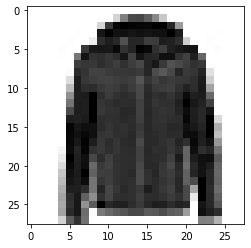

In [3]:
# 数据集样本展示
def show_single_img(img_arr):
    plt.imshow(img_arr, cmap="binary")
    plt.show()
show_single_img(x_train[0])

In [4]:
'''
对数据进行归一化处理
定义：把数据经过处理后使之限定在一定的范围内。比如通常限制在区间[0, 1]或者[-1, 1]
Z-score归一化
'''
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
x_train_scaled = scaler.fit_transform(x_train.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_valid_scaled = scaler.fit_transform(x_valid.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
x_test_scaled = scaler.fit_transform(x_test.astype(np.float32).reshape(-1, 1)).reshape(-1, 28, 28)
# 我们np里的数据是int类型，所以我们需要x_train.astype(np.float32)将数据转化成float32
# fit_transform 不仅有数据转化为归一化的功能，还有fit（将数据存储下来）的功能.
# Z_score = lambda d:scaler.fit_transform(d.astype(np.float32).reshape(-1,1)).reshape(-1,28,28)
# x_train_scaled = Z_score(x_train)
# x_valid_scaled = Z_score(x_valid)
# x_test_scaled = Z_score(x_test)

In [5]:
model = keras.models.Sequential()
# padding='same' 要不要给输入加上padding
model.add(keras.layers.Conv2D(filters=32, kernel_size=3, padding='same', activation='relu', input_shape=(28,28,1)))
model.add(keras.layers.SeparableConv2D(filters=32, kernel_size=3, padding='same', activation='relu'))
# pool_size=2 源数据的长宽都会变成原来的1/2，导致数据量变为原来的1/4
model.add(keras.layers.MaxPool2D(pool_size=2))

# 所以在这一层需要讲filter变成两倍，防止损失数据
model.add(keras.layers.Conv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.SeparableConv2D(filters=64, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

# 以下同理
model.add(keras.layers.Conv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.SeparableConv2D(filters=128, kernel_size=3, padding='same', activation='relu'))
model.add(keras.layers.MaxPool2D(pool_size=2))

# 链接全连接层
model.add(keras.layers.Flatten())
model.add(keras.layers.Dense(128, activation='relu'))
# 输出层
model.add(keras.layers.Dense(10, activation='softmax'))

model.compile(loss='sparse_categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
separable_conv2d (SeparableC (None, 28, 28, 32)        1344      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
separable_conv2d_1 (Separabl (None, 14, 14, 64)        4736      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 7, 7, 128)         7

In [6]:
x_train_scaled.shape[0]

55000

In [7]:
logdir = os.path.join('callbacks')

if not os.path.exists(logdir):
    os.mkdir(logdir)
output_model_file = os.path.join(logdir,
                                 "fashion_mnist_model.h5")
callbacks = [
    keras.callbacks.TensorBoard(log_dir=logdir),
    keras.callbacks.ModelCheckpoint(output_model_file, save_best_only=True),
    keras.callbacks.EarlyStopping(patience=5, min_delta=1e-3),
]


from keras.utils import np_utils
# 将数据集标准化

x_train_scaled = x_train_scaled.reshape(x_train_scaled.shape[0],28,28,1)
x_valid_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0],28,28,1)
x_test_scaled = x_valid_scaled.reshape(x_valid_scaled.shape[0],28,28,1)

history = model.fit(x_train_scaled, y_train, epochs=10, validation_data=(x_valid_scaled, y_valid), callbacks=callbacks)

Using TensorFlow backend.


Train on 55000 samples, validate on 5000 samples
Epoch 1/10
55000/55000 [==============================] - 19s 344us/sample - loss: 2.3026 - accuracy: 0.1008 - val_loss: 2.3027 - val_accuracy: 0.0986
Epoch 2/10
55000/55000 [==============================] - 14s 262us/sample - loss: 2.3026 - accuracy: 0.1007 - val_loss: 2.3027 - val_accuracy: 0.0986
Epoch 3/10
55000/55000 [==============================] - 15s 269us/sample - loss: 2.3025 - accuracy: 0.1024 - val_loss: 2.3024 - val_accuracy: 0.0986
Epoch 4/10
55000/55000 [==============================] - 15s 278us/sample - loss: 2.3023 - accuracy: 0.1045 - val_loss: 2.3022 - val_accuracy: 0.0914
Epoch 5/10
55000/55000 [==============================] - 15s 272us/sample - loss: 2.3016 - accuracy: 0.1108 - val_loss: 2.3004 - val_accuracy: 0.0980
Epoch 6/10
55000/55000 [==============================] - 15s 272us/sample - loss: 2.1338 - accuracy: 0.2406 - val_loss: 1.0289 - val_accuracy: 0.6426
Epoch 7/10
55000/55000 [=====================

In [8]:
x_train_scaled

array([[[[-0.8105136],
         [-0.8105136],
         [-0.8105136],
         ...,
         [-0.8105136],
         [-0.8105136],
         [-0.8105136]],

        [[-0.8105136],
         [-0.8105136],
         [-0.8105136],
         ...,
         [-0.8105136],
         [-0.8105136],
         [-0.8105136]],

        [[-0.8105136],
         [-0.8105136],
         [-0.8105136],
         ...,
         [-0.8105136],
         [-0.8105136],
         [-0.8105136]],

        ...,

        [[-0.8105136],
         [-0.8105136],
         [-0.8105136],
         ...,
         [-0.8105136],
         [-0.8105136],
         [-0.8105136]],

        [[-0.8105136],
         [-0.8105136],
         [-0.8105136],
         ...,
         [-0.8105136],
         [-0.8105136],
         [-0.8105136]],

        [[-0.8105136],
         [-0.8105136],
         [-0.8105136],
         ...,
         [-0.8105136],
         [-0.8105136],
         [-0.8105136]]],


       [[[-0.8105136],
         [-0.8105136],
         [-0.8

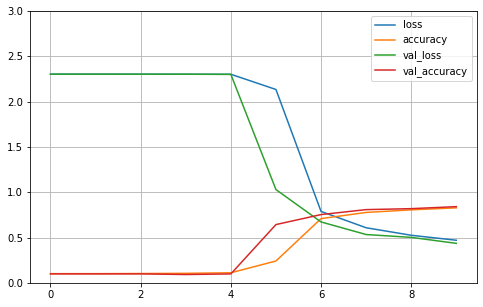

In [11]:
def plot_learning_curves(history):
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 3)
    plt.show()

plot_learning_curves(history)

In [10]:
print(y_test.shape)
model.evaluate(x_test_scaled, y_test[:5000])

(10000,)
5000/5000 [==============================] - 1s 119us/sample - loss: 8.8059 - accuracy: 0.1018


[8.805856645965576, 0.1018]